# Multi-Layer Perceptron from Scratch


This notebook builds a fully connected neural network using only NumPy and the Python standard library.

**Notebook outline**

- Load a mock multi-class classification dataset.\n
- Implement reusable activation functions and training utilities.
- Build an `MLP` class that supports forward pass, backpropagation, and gradient updates.
- Train the network with mini-batch gradient descent and evaluate its performance.
- Visualise decision boundaries and learning curves.


In [1]:
from __future__ import annotations

import math
from pathlib import Path
from typing import Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)
plt.style.use("ggplot")


In [2]:
DATASET_PATH = Path("../data/mock_classification.csv")

if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Expected dataset at {DATASET_PATH}. Run the data preparation script first."
    )

data = np.loadtxt(DATASET_PATH, delimiter=",", skiprows=1)

X = data[:, :2]
y = data[:, 2].astype(int)

num_samples, num_features = X.shape
num_classes = int(y.max() + 1)

print(f"Loaded {num_samples} samples with {num_features} features and {num_classes} classes.")


Loaded 900 samples with 2 features and 3 classes.


In [3]:
def train_test_split(
    X: np.ndarray,
    y: np.ndarray,
    test_ratio: float = 0.2,
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    indices = np.arange(X.shape[0])
    rng.shuffle(indices)

    test_size = int(np.floor(test_ratio * len(indices)))
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    return (
        X[train_indices],
        X[test_indices],
        y[train_indices],
        y[test_indices],
    )


X_train, X_test, y_train, y_test = train_test_split(X, y, test_ratio=0.2, seed=123)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set:  {X_test.shape[0]} samples")


Train set: 720 samples
Test set:  180 samples


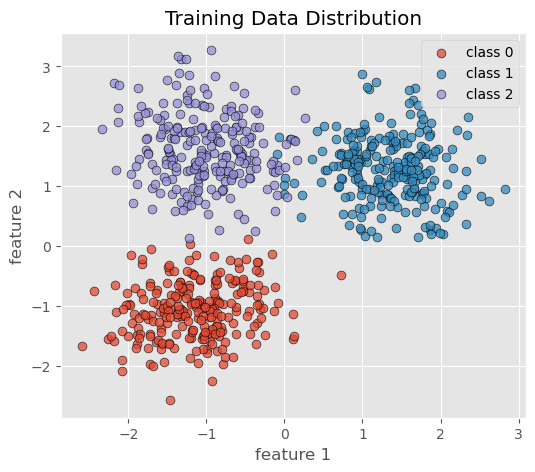

In [4]:
def plot_data(X: np.ndarray, y: np.ndarray, title: str) -> None:
    plt.figure(figsize=(6, 5))
    for cls in np.unique(y):
        plt.scatter(
            X[y == cls, 0],
            X[y == cls, 1],
            label=f"class {cls}",
            alpha=0.75,
            edgecolor="k",
            s=40,
        )
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title(title)
    plt.legend()
    plt.show()


plot_data(X_train, y_train, "Training Data Distribution")


In [5]:
def one_hot(indices: np.ndarray, depth: int) -> np.ndarray:
    encoded = np.zeros((indices.size, depth), dtype=np.float64)
    encoded[np.arange(indices.size), indices] = 1.0
    return encoded


def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, z)


def relu_derivative(z: np.ndarray) -> np.ndarray:
    return (z > 0).astype(np.float64)


def softmax(logits: np.ndarray) -> np.ndarray:
    shifted = logits - np.max(logits, axis=1, keepdims=True)
    exp_values = np.exp(shifted)
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)


def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true == y_pred))


In [6]:
class MLP:
    def __init__(self, layer_sizes: Iterable[int], learning_rate: float = 0.05, l2: float = 0.0) -> None:
        sizes = tuple(layer_sizes)
        if len(sizes) < 2:
            raise ValueError("layer_sizes must include at least an input and an output dimension.")
        self.layer_sizes = sizes
        self.learning_rate = learning_rate
        self.l2 = l2

        self.weights: list[np.ndarray] = []
        self.biases: list[np.ndarray] = []

        rng = np.random.default_rng(42)
        for idx in range(len(sizes) - 1):
            in_features = sizes[idx]
            out_features = sizes[idx + 1]
            if idx == len(sizes) - 2:
                scale = np.sqrt(1.0 / in_features)
            else:
                scale = np.sqrt(2.0 / in_features)
            weight_matrix = rng.normal(loc=0.0, scale=scale, size=(in_features, out_features))
            bias_vector = np.zeros((1, out_features), dtype=np.float64)
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

        self._cache: dict[str, list[np.ndarray]] = {}
        self._grads: dict[str, list[np.ndarray]] = {}

    def forward(self, X: np.ndarray, store: bool = True) -> np.ndarray:
        activations = [X]
        pre_activations = []
        current = X

        for idx, (weights, bias) in enumerate(zip(self.weights, self.biases)):
            z = current @ weights + bias
            pre_activations.append(z)
            if idx == len(self.weights) - 1:
                current = softmax(z)
            else:
                current = relu(z)
            activations.append(current)

        if store:
            self._cache = {
                "activations": activations,
                "pre_activations": pre_activations,
            }

        return current

    def compute_loss(self, y_one_hot: np.ndarray, probabilities: np.ndarray) -> float:
        eps = 1e-12
        batch_size = y_one_hot.shape[0]
        ce = -np.sum(y_one_hot * np.log(probabilities + eps)) / batch_size
        if self.l2:
            ce += 0.5 * self.l2 * sum(np.sum(w * w) for w in self.weights)
        return float(ce)

    def backward(self, y_one_hot: np.ndarray) -> None:
        if not self._cache:
            raise RuntimeError("Nothing to backpropagate. Call forward(store=True) before backward().")

        activations = self._cache["activations"]
        pre_activations = self._cache["pre_activations"]
        batch_size = y_one_hot.shape[0]

        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        delta = activations[-1] - y_one_hot

        for layer in reversed(range(len(self.weights))):
            grads_w[layer] = (activations[layer].T @ delta) / batch_size + self.l2 * self.weights[layer]
            grads_b[layer] = np.sum(delta, axis=0, keepdims=True) / batch_size

            if layer != 0:
                delta = (delta @ self.weights[layer].T) * relu_derivative(pre_activations[layer - 1])

        self._grads = {"weights": grads_w, "biases": grads_b}

    def _apply_gradients(self) -> None:
        if not self._grads:
            raise RuntimeError("Call backward() before applying gradients.")

        for idx in range(len(self.weights)):
            self.weights[idx] -= self.learning_rate * self._grads["weights"][idx]
            self.biases[idx] -= self.learning_rate * self._grads["biases"][idx]

    def train_batch(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        y_one_hot = one_hot(y, self.layer_sizes[-1])
        probabilities = self.forward(X, store=True)
        loss = self.compute_loss(y_one_hot, probabilities)
        self.backward(y_one_hot)
        self._apply_gradients()
        predictions = np.argmax(probabilities, axis=1)
        batch_accuracy = accuracy_score(y, predictions)
        return loss, batch_accuracy

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.forward(X, store=False)

    def predict(self, X: np.ndarray) -> np.ndarray:
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


In [7]:
def iterate_minibatches(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int,
    shuffle: bool = True,
    seed: int | None = None,
) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
    indices = np.arange(X.shape[0])
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

    for start in range(0, len(indices), batch_size):
        excerpt = indices[start : start + batch_size]
        yield X[excerpt], y[excerpt]


def evaluate(model: MLP, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    probabilities = model.predict_proba(X)
    y_one_hot = one_hot(y, model.layer_sizes[-1])
    loss = model.compute_loss(y_one_hot, probabilities)
    predictions = np.argmax(probabilities, axis=1)
    acc = accuracy_score(y, predictions)
    return loss, acc


In [8]:
learning_rate = 0.05
hidden_layers = [16, 8]
epochs = 200
batch_size = 32
l2_strength = 1e-4

layer_sizes = [num_features, *hidden_layers, num_classes]
model = MLP(layer_sizes, learning_rate=learning_rate, l2=l2_strength)

history: dict[str, list[float]] = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(epochs):
    batch_losses = []
    batch_accs = []

    for X_batch, y_batch in iterate_minibatches(
        X_train, y_train, batch_size=batch_size, shuffle=True, seed=epoch
    ):
        loss, acc = model.train_batch(X_batch, y_batch)
        batch_losses.append(loss)
        batch_accs.append(acc)

    train_loss = float(np.mean(batch_losses))
    train_acc = float(np.mean(batch_accs))
    val_loss, val_acc = evaluate(model, X_test, y_test)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(
            f"Epoch {epoch + 1:03d} | "
            f"train loss {train_loss:.4f} | train acc {train_acc:.3f} | "
            f"val loss {val_loss:.4f} | val acc {val_acc:.3f}"
        )


Epoch 001 | train loss 0.9696 | train acc 0.524 | val loss 0.7199 | val acc 0.739
Epoch 020 | train loss 0.0471 | train acc 0.981 | val loss 0.0244 | val acc 1.000
Epoch 040 | train loss 0.0377 | train acc 0.981 | val loss 0.0131 | val acc 1.000
Epoch 060 | train loss 0.0335 | train acc 0.984 | val loss 0.0104 | val acc 1.000
Epoch 080 | train loss 0.0349 | train acc 0.981 | val loss 0.0098 | val acc 0.994
Epoch 100 | train loss 0.0302 | train acc 0.984 | val loss 0.0091 | val acc 1.000
Epoch 120 | train loss 0.0303 | train acc 0.985 | val loss 0.0090 | val acc 1.000
Epoch 140 | train loss 0.0296 | train acc 0.988 | val loss 0.0090 | val acc 1.000
Epoch 160 | train loss 0.0293 | train acc 0.986 | val loss 0.0090 | val acc 1.000
Epoch 180 | train loss 0.0283 | train acc 0.986 | val loss 0.0093 | val acc 1.000
Epoch 200 | train loss 0.0284 | train acc 0.986 | val loss 0.0090 | val acc 1.000


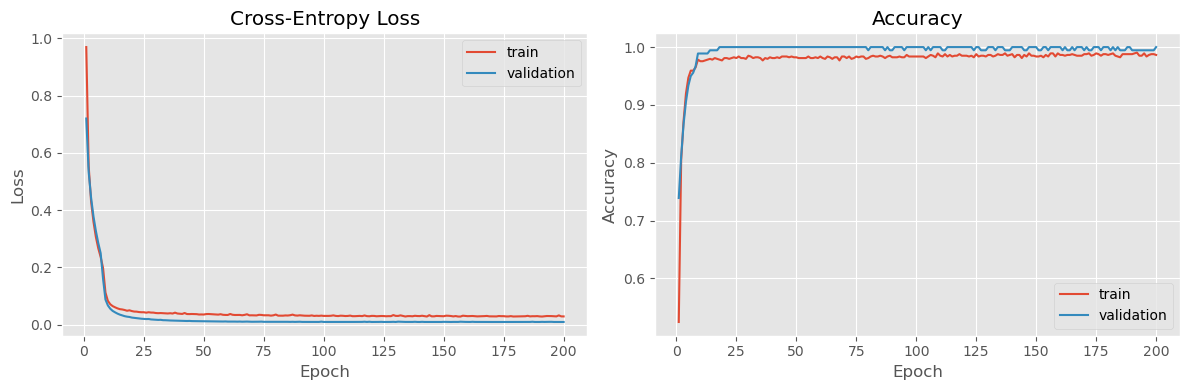

In [9]:
epochs_axis = np.arange(1, epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs_axis, history["train_loss"], label="train")
axes[0].plot(epochs_axis, history["val_loss"], label="validation")
axes[0].set_title("Cross-Entropy Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(epochs_axis, history["train_acc"], label="train")
axes[1].plot(epochs_axis, history["val_acc"], label="validation")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


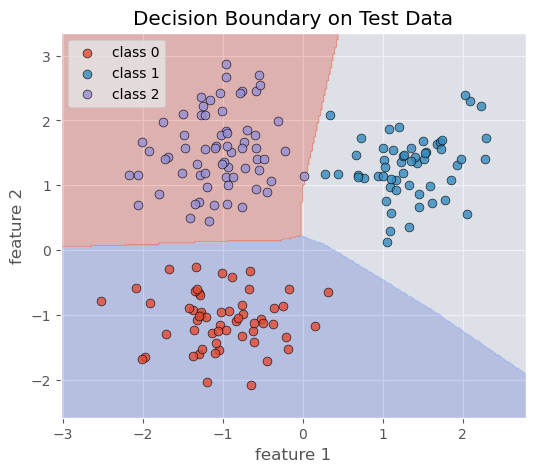

In [10]:
def plot_decision_boundary(
    model: MLP,
    X: np.ndarray,
    y: np.ndarray,
    title: str = "Decision Boundary",
    grid_step: float = 0.02,
) -> None:
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step),
        np.arange(y_min, y_max, grid_step),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    probabilities = model.predict_proba(grid)
    predictions = np.argmax(probabilities, axis=1).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, predictions, alpha=0.3, cmap=plt.cm.coolwarm)

    for cls in np.unique(y):
        plt.scatter(
            X[y == cls, 0],
            X[y == cls, 1],
            label=f"class {cls}",
            edgecolor="k",
            alpha=0.8,
            s=40,
        )

    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.title(title)
    plt.legend()
    plt.show()


plot_decision_boundary(model, X_test, y_test, title="Decision Boundary on Test Data")


In [11]:
sample_points = X_test[:5]
predicted_labels = model.predict(sample_points)

print("Predicted:", predicted_labels)
print("Ground truth:", y_test[:5])


Predicted: [1 1 0 2 1]
Ground truth: [1 1 0 2 1]


## Next steps

- Experiment with different activation functions (e.g. sigmoid, tanh) or deeper architectures by modifying `hidden_layers`.
- Try alternative optimisation strategies such as momentum or RMSProp to accelerate convergence.
- Replace the mock dataset with your own data by saving it to `../data/mock_classification.csv` with the same schema.
